In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns 
from pandas.plotting import scatter_matrix
from decisionboundaryplot import DBPlot

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import diffprivlib as dp

import nbfuns
import importlib
importlib.reload(nbfuns)

import statsmodels.api as sm
import sys
import warnings

%matplotlib inline
#%matplotlib notebook

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
CLF_RANDOM_STATE=1234
DP_CLF_RANDOM_STATE=13371337
SHADOW_RANDOM_STATE=22222222
SPLIT_RANDOM_STATE=303030
RF_RANDOM_STATE=51516321

In [2]:
df = pd.read_csv('./datasets/adult/adult-preprocessed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   index            48842 non-null  int64
 1   age              48842 non-null  int64
 2   workclass        48842 non-null  int64
 3   education        48842 non-null  int64
 4   educational-num  48842 non-null  int64
 5   marital-status   48842 non-null  int64
 6   occupation       48842 non-null  int64
 7   relationship     48842 non-null  int64
 8   race             48842 non-null  int64
 9   gender           48842 non-null  int64
 10  capital-gain     48842 non-null  int64
 11  capital-loss     48842 non-null  int64
 12  hours-per-week   48842 non-null  int64
 13  native-country   48842 non-null  int64
 14  income           48842 non-null  int64
dtypes: int64(15)
memory usage: 5.6 MB


In [3]:
df.describe()

index           age     workclass     education  \
count  48842.000000  48842.000000  48842.000000  48842.000000   
mean   24420.500000     38.643585      3.870439     10.288420   
std    14099.615261     13.710510      1.464234      3.874492   
min        0.000000     17.000000      0.000000      0.000000   
25%    12210.250000     28.000000      4.000000      9.000000   
50%    24420.500000     37.000000      4.000000     11.000000   
75%    36630.750000     48.000000      4.000000     12.000000   
max    48841.000000     90.000000      8.000000     15.000000   

       educational-num  marital-status    occupation  relationship  \
count     48842.000000    48842.000000  48842.000000  48842.000000   
mean         10.078089        0.528193      6.577700      1.443287   
std           2.570973        0.499210      4.230509      1.602151   
min           1.000000        0.000000      0.000000      0.000000   
25%           9.000000        0.000000      3.000000      0.000000   
50%          10.000000        1.000000      7.000000      1.000000   
75%          12.000000        1.000000     10.000000      3.000000   
max          16.000000        1.000000     14.000000      5.000000   

               race        gender  capital-gain  capital-loss  hours-per-week  \
count  48842.000000  48842.000000  48842.000000  48842.000000    48842.000000   
mean       3.668052      0.668482   1079.067626     87.502314       40.422382   
std        0.845986      0.470764   7452.019058    403.004552       12.391444   
min        0.000000      0.000000      0.000000      0.000000        1.000000   
25%        4.000000      0.000000      0.000000      0.000000       40.000000   
50%        4.000000      1.000000      0.000000      0.000000       40.000000   
75%        4.000000      1.000000      0.000000      0.000000       45.000000   
max        4.000000      1.000000  99999.000000   4356.000000       99.000000   

       native-country        income  
count    48842.000000  48842.000000  
mean        36.749355      0.239282  
std          7.775343      0.426649  
min          0.000000      0.000000  
25%         39.000000      0.000000  
50%         39.000000      0.000000  
75%         39.000000      0.000000  
max         41.000000      1.000000

In [4]:
df.head()

index  age  workclass  education  educational-num  marital-status  \
0      0   25          4          1                7               1   
1      1   38          4         11                9               0   
2      2   28          2          7               12               0   
3      3   44          4         15               10               0   
4      4   18          0         15               10               1   

   occupation  relationship  race  gender  capital-gain  capital-loss  \
0           7             3     2       1             0             0   
1           5             0     4       1             0             0   
2          11             0     4       1             0             0   
3           7             0     2       1          7688             0   
4           0             3     4       0             0             0   

   hours-per-week  native-country  income  
0              40              39       0  
1              50              39       0  
2              40              39       1  
3              40              39       1  
4              30              39       0

In [5]:
def adult_gen_xs_ys(df):
    cols = df.columns
    cols = cols.drop(labels="income")
    x = pd.DataFrame(df, columns=cols)
    y = pd.DataFrame(df, columns=["income", "index"])
    return x, y

array([[<AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'index'}>]], dtype=object)

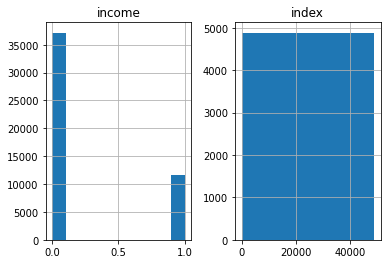

In [6]:
x, y = adult_gen_xs_ys(df)
y.hist()

In [7]:
print(f'Distribution in original set:  \n{y.income.value_counts().sort_index() / len(y)}')

Distribution in original set:  
0    0.760718
1    0.239282
Name: income, dtype: float64


In [8]:
n_train = len(df) // 2
df_train = df.sample(n=n_train,  replace=False, random_state=SPLIT_RANDOM_STATE)
df_train.income.value_counts().sort_index()
print(n_train)

24421


In [9]:
df_test = df.merge(df_train.drop_duplicates(), on=None, 
                   how='left', indicator=True)
df_test = df_test[df_test['_merge'] == 'left_only']
df_test.drop(labels='_merge', axis=1, inplace=True)
df_test

index  age  workclass  education  educational-num  marital-status  \
4          4   18          0         15               10               1   
5          5   34          4          0                6               1   
10        10   65          4         11                9               0   
12        12   26          4         11                9               1   
13        13   58          0         11                9               0   
...      ...  ...        ...        ...              ...             ...   
48829  48829   65          6         14               15               1   
48832  48832   32          4          0                6               0   
48833  48833   43          4          8               11               0   
48835  48835   53          4         12               14               0   
48841  48841   52          5         11                9               0   

       occupation  relationship  race  gender  capital-gain  capital-loss  \
4               0             3     4       0             0             0   
5               8             1     4       1             0             0   
10              7             0     4       1          6418             0   
12              1             1     4       0             0             0   
13              0             0     4       1             0             0   
...           ...           ...   ...     ...           ...           ...   
48829          10             1     4       1          1086             0   
48832           6             0     0       1             0             0   
48833          12             0     4       1             0             0   
48835           4             0     4       1             0             0   
48841           4             5     4       0         15024             0   

       hours-per-week  native-country  income  
4                  30              39       0  
5                  30              39       0  
10                 40              39       1  
12                 39              39       0  
13                 35              39       0  
...               ...             ...     ...  
48829              60              39       0  
48832              40              39       0  
48833              45              39       0  
48835              40              39       1  
48841              40              39       1  

[24421 rows x 15 columns]

In [10]:
# Here we check for duplicates and see that there is no intersection between the two sets.
s1 = pd.merge(df_train, df_test, how='inner')
s1

Empty DataFrame
Columns: [index, age, workclass, education, educational-num, marital-status, occupation, relationship, race, gender, capital-gain, capital-loss, hours-per-week, native-country, income]
Index: []

In [11]:
X_train, y_train = adult_gen_xs_ys(df_train)
X_test, y_test = adult_gen_xs_ys(df_test)
X_train

index  age  workclass  education  educational-num  marital-status  \
9312    9312   32          0         11                9               0   
31028  31028   49          4         11                9               1   
17067  17067   61          6         11                9               0   
5165    5165   27          2         11                9               0   
23560  23560   51          4         11                9               0   
...      ...  ...        ...        ...              ...             ...   
41113  41113   26          4          9               13               1   
20991  20991   26          4         15               10               1   
5721    5721   36          4          9               13               1   
28247  28247   55          4          4                3               1   
2873    2873   31          4          9               13               1   

       occupation  relationship  race  gender  capital-gain  capital-loss  \
9312            0             0     2       1             0             0   
31028           3             1     4       1             0          1876   
17067           5             0     4       1             0          2352   
5165           11             0     1       1             0             0   
23560          12             1     2       0             0             0   
...           ...           ...   ...     ...           ...           ...   
41113           4             1     4       1             0             0   
20991           3             1     4       1             0             0   
5721           13             3     4       1             0             0   
28247           7             4     4       0             0             0   
2873           12             1     4       1             0             0   

       hours-per-week  native-country  
9312               45              39  
31028              40              39  
17067              50              39  
5165               40              39  
23560              38              39  
...               ...             ...  
41113              60               0  
20991              43              39  
5721               40              39  
28247              40              39  
2873               48              39  

[24421 rows x 14 columns]

In [12]:
# we dont need indices so we just extract the incomes
X_train.drop(labels="index", axis=1, inplace=True)
X_test.drop(labels="index", axis=1, inplace=True)
y_train.drop(labels="index", axis=1, inplace=True)
y_test.drop(labels="index", axis=1, inplace=True)

In [13]:
y_test.value_counts()

income
0         18560
1          5861
dtype: int64

In [14]:
# Logistic regression with no privacy guarantees
clf = LogisticRegression(solver="lbfgs", random_state=CLF_RANDOM_STATE)
clf.fit(X_train, y_train)

LogisticRegression(random_state=1234)

In [15]:
y_test.head()

income
4        0
5        0
10       1
12       0
13       0

In [16]:
baseline = clf.score(X_test, y_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

In [76]:
from sklearn.utils import resample
y_train.describe()
df_majority = df_train[df_train.income == 0]
df_minority = df_train[df_train.income == 1]
df_minority

df_maj_downsampled = resample(df_majority, replace=False, n_samples=50)
df_min_upsamples = resample(df_minority, replace=False, n_samples=50)

df_mixed = pd.concat([df_maj_downsampled, df_min_upsamples])
df_mixed.drop(columns="index", axis=1, inplace=True)
df_mixed
x_mixed = df_mixed.drop(columns="income", axis=1, inplace=False).to_numpy()
y_mixed = df_mixed.income.to_numpy()

(100,)

Non-private test accuracy: 83.89%
Step 1/3: 0/16
Step 1/3: 1/16
Step 1/3: 2/16
Step 1/3: 3/16
Step 1/3: 4/16
Step 1/3: 5/16
Step 1/3: 6/16
Step 1/3: 7/16
Step 1/3: 8/16
Step 1/3: 9/16
Step 1/3: 10/16
Step 1/3: 11/16
Step 1/3: 12/16
Step 1/3: 13/16
Step 1/3: 14/16
Step 1/3: 15/16
Step 2/3: 0/20
Step 2/3: 1/20
Step 2/3: 2/20
Step 2/3: 3/20
Step 2/3: 4/20
Step 2/3: 5/20
Step 2/3: 6/20
Step 2/3: 7/20
Step 2/3: 8/20
Step 2/3: 9/20
Step 2/3: 10/20
Step 2/3: 11/20
Step 2/3: 12/20
Step 2/3: 13/20
Step 2/3: 14/20
Step 2/3: 15/20
Step 2/3: 16/20
Step 2/3: 18/20
Step 2/3: 19/20
Step 3/3:0/
Step 3/3:1/
Step 3/3:2/
Step 3/3:3/
Step 3/3:4/
Step 3/3:5/
Step 3/3:6/
Step 3/3:7/
Step 3/3:8/
Step 3/3:9/
Step 3/3:10/
Step 3/3:11/
Step 3/3:12/
Step 3/3:13/
Step 3/3:14/
Step 3/3:15/
Step 3/3:16/
Step 3/3:17/
Step 3/3:18/
Step 3/3:19/
Step 3/3:20/
Step 3/3:21/
Step 3/3:22/
Step 3/3:23/
Step 3/3:24/
Step 3/3:25/
Step 3/3:26/
Step 3/3:27/
Step 3/3:28/
Step 3/3:29/
Step 3/3:30/
Step 3/3:31/
Step 3/3:32/
Step 3/

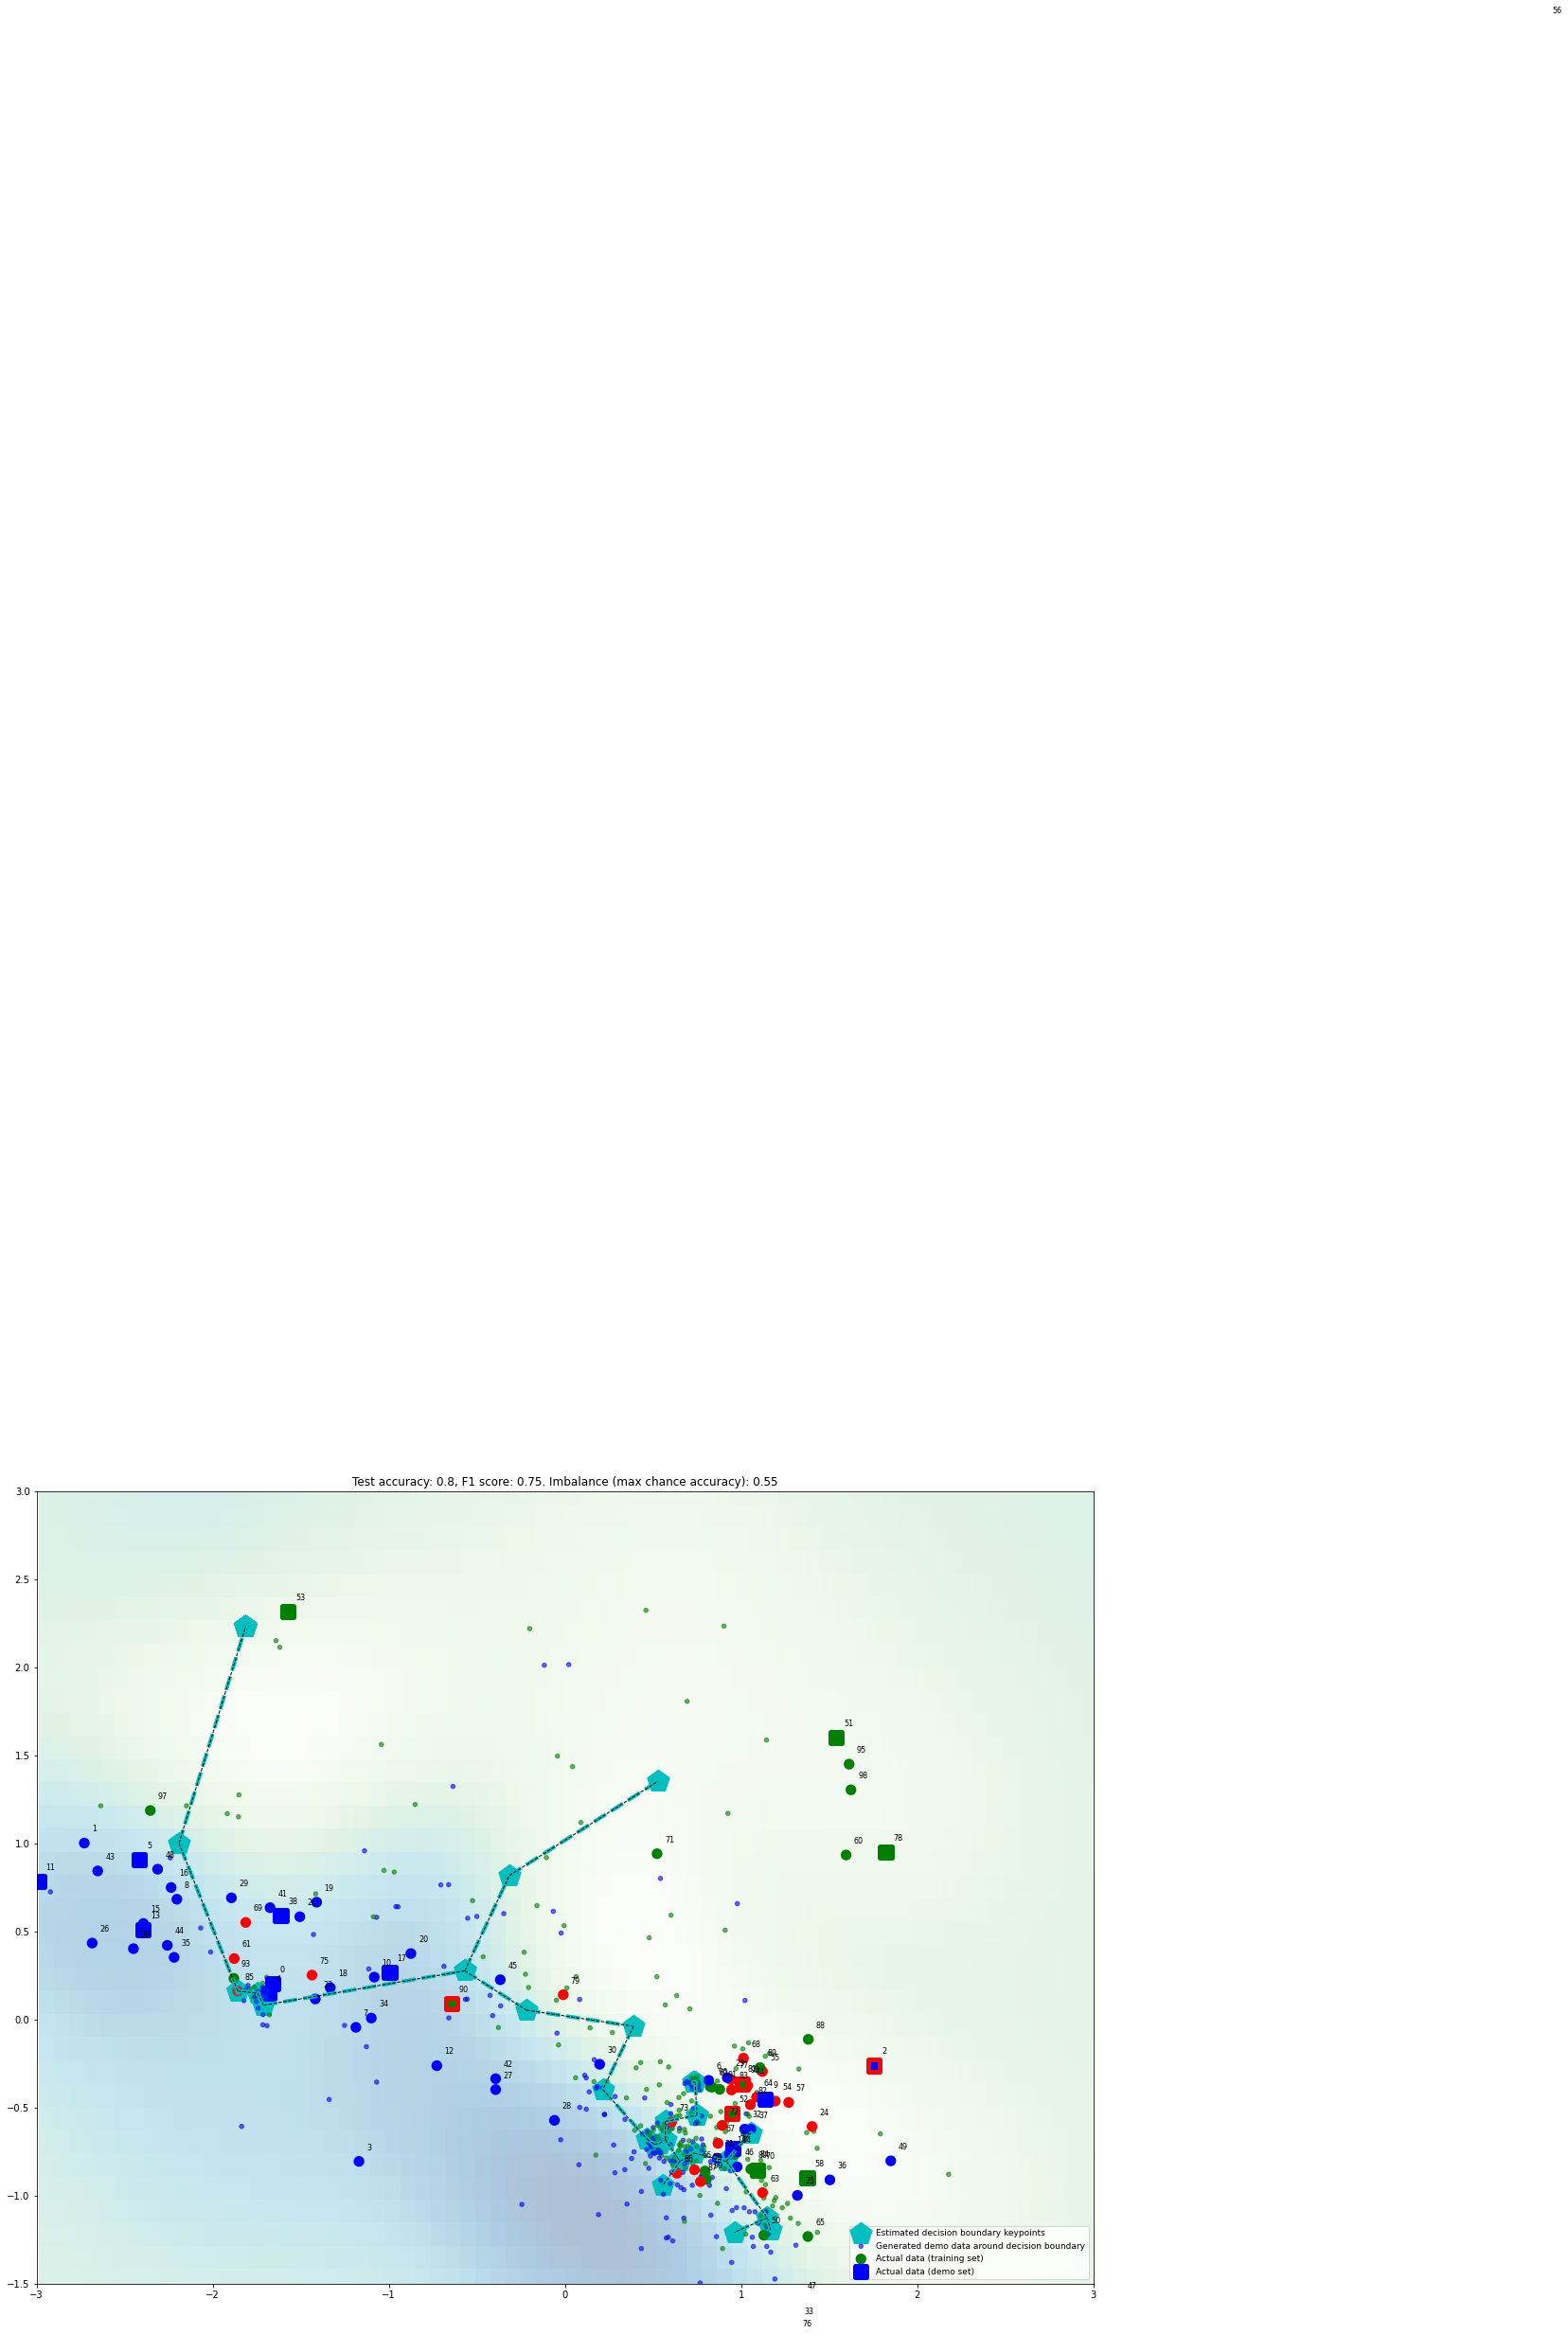

In [93]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_np = X_train.to_numpy()
y_np = y_train.income.to_numpy()

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X_np)
x_mixed_transformed = scaler.transform(x_mixed)

clf = LogisticRegression(solver="lbfgs", random_state=CLF_RANDOM_STATE)
clf.fit(X_transformed, y_np)
baseline = clf.score(scaler.transform(X_test), y_test.income.to_numpy())
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

plt.figure(figsize=(20, 20))
db = DBPlot(clf, PCA(n_components=2))
db.fit(x_mixed_transformed, y_mixed, training_indices=0.5)
fig = db.plot(plt, generate_testpoints=True)
plt.xlim((-3, 3))
plt.ylim((-1.5, 3))
#fig.show()
plt.savefig("./adult-logistic-decision-boundaries.svg")

In [ ]:
dp_clf = dp.models.LogisticRegression(epsilon=1.0, data_norm=100)
dp_clf.fit(X_train, y_train)

LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1.0, 0)]),
                   data_norm=100)

In [19]:
print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
     (dp_clf.epsilon, dp_clf.score(X_test, y_test) * 100))

Differentially private test accuracy (epsilon=1.00): 67.49%


In [20]:
print("Agreement between non-private and differentially private (epsilon=inf) classifiers: %.2f%%" % 
     (dp_clf.score(X_test, clf.predict(X_test)) * 100))

Agreement between non-private and differentially private (epsilon=inf) classifiers: 76.62%


### By setting epsilon = float("inf"), we can produce the same result as the non-private logistic regression classifer:

Non-private test accuracy: 83.89%
Step 1/3: 0/16
Step 1/3: 1/16
Step 1/3: 2/16
Step 1/3: 3/16
Step 1/3: 4/16
Step 1/3: 5/16
Step 1/3: 7/16
Step 1/3: 8/16
Step 1/3: 9/16
Step 1/3: 11/16
Step 1/3: 12/16
Step 1/3: 13/16
Step 1/3: 14/16
Step 1/3: 15/16
Step 2/3: 0/20
Step 2/3: 1/20
Step 2/3: 2/20
Step 2/3: 3/20
Step 2/3: 4/20
Step 2/3: 5/20
Step 2/3: 6/20
Step 2/3: 7/20
Step 2/3: 8/20
Step 2/3: 9/20
Step 2/3: 11/20
Step 2/3: 13/20
Step 2/3: 14/20
Step 2/3: 15/20
Step 2/3: 18/20
Step 2/3: 19/20
Step 3/3:0/
No good solution along straight line - trying to find decision boundary on hypersphere surface around known decision boundary point
Found point is too distant from decision boundary (0.5) retrying...
Step 3/3:0/
No good solution along straight line - trying to find decision boundary on hypersphere surface around known decision boundary point
Found point is too distant from decision boundary (0.5) retrying...
Step 3/3:0/
No good solution along straight line - trying to find decision bounda

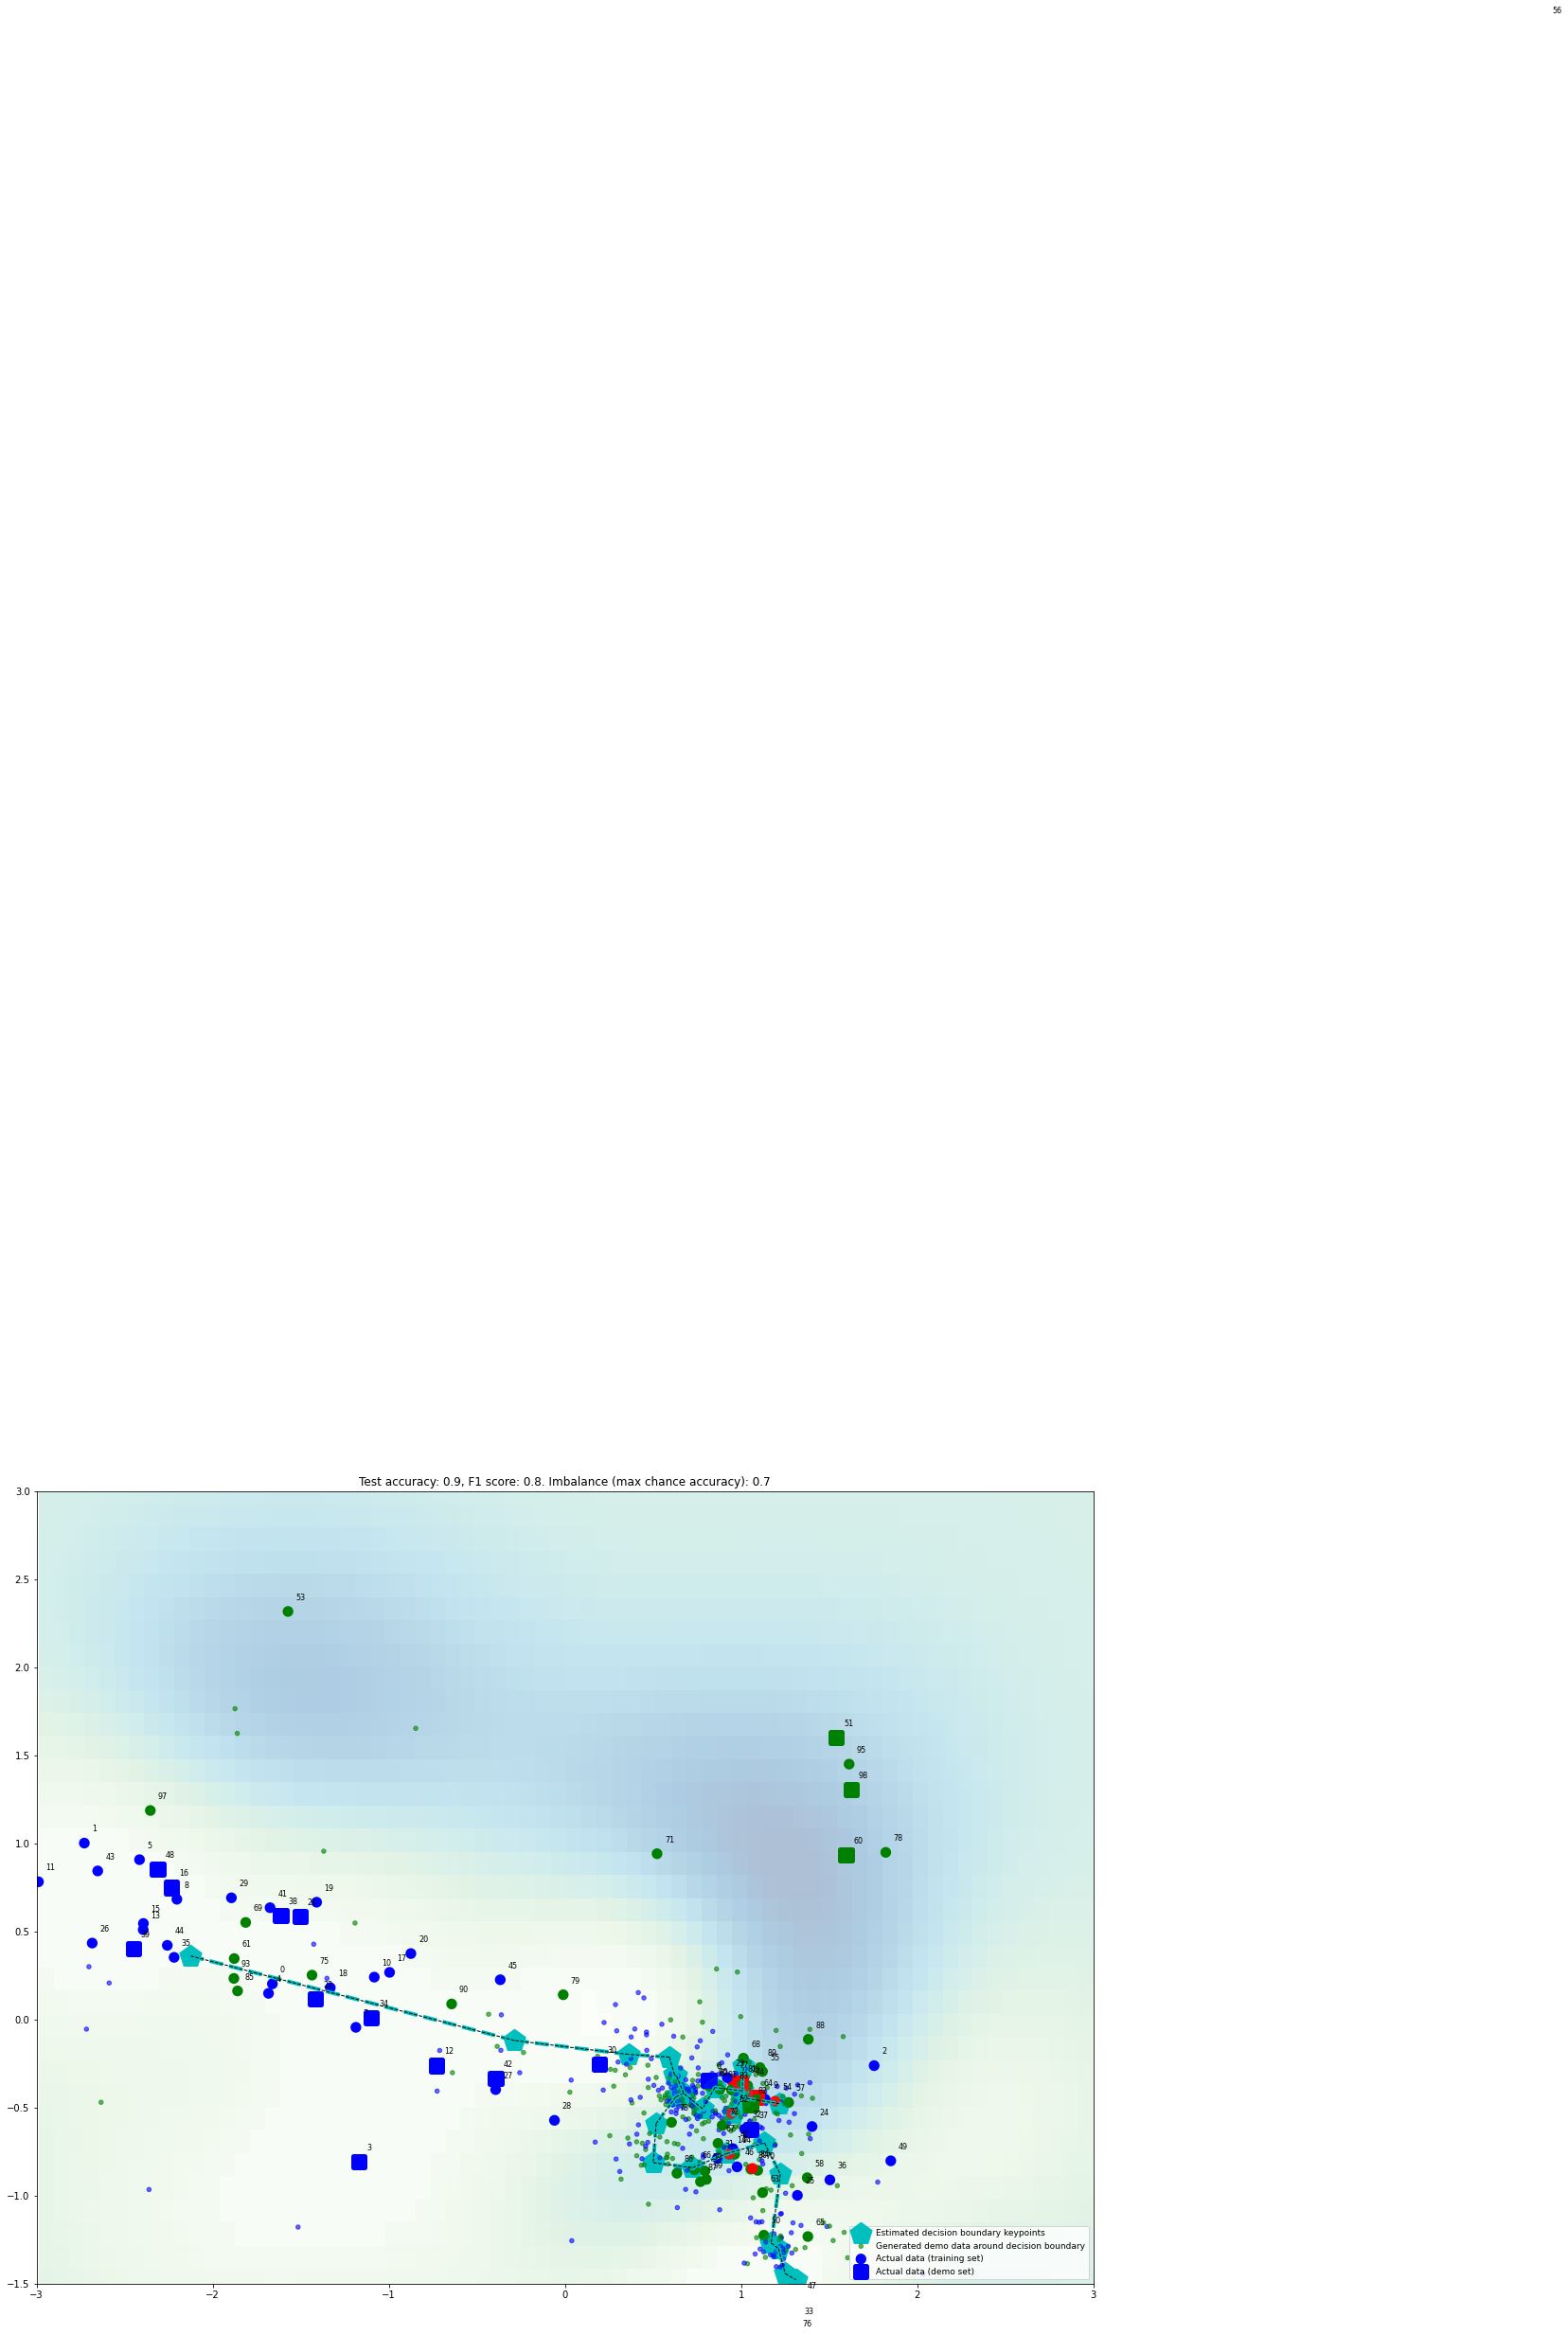

In [94]:
from sklearn import tree

X_np = X_train.to_numpy()
y_np = y_train.income.to_numpy()

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X_np)
x_mixed_transformed = scaler.transform(x_mixed)

dt = tree.DecisionTreeClassifier()
dt.fit(X_transformed, y_np)
baseline = clf.score(scaler.transform(X_test), y_test.income.to_numpy())
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

plt.figure(figsize=(20, 20))
db = DBPlot(dt, PCA(n_components=2))
db.fit(x_mixed_transformed, y_mixed, training_indices=0.5)
fig = db.plot(plt, generate_testpoints=True)
plt.xlim((-3, 3))
plt.ylim((-1.5, 3))
#fig.show()
plt.savefig("./adult-decisiontree-decision-boundaries.svg")

Non-private test accuracy: 84.40%
Step 1/3: 0/16
Step 1/3: 1/16
Step 1/3: 2/16
Step 1/3: 3/16
Step 1/3: 4/16
Step 1/3: 5/16
Step 1/3: 7/16
Step 1/3: 8/16
Step 1/3: 9/16
Step 1/3: 10/16
Step 1/3: 11/16
Step 1/3: 12/16
Step 1/3: 13/16
Step 1/3: 14/16
Step 1/3: 15/16
Step 2/3: 1/20
Step 2/3: 2/20
Step 2/3: 3/20
Step 2/3: 4/20
Step 2/3: 5/20
Step 2/3: 6/20
Step 2/3: 7/20
Step 2/3: 8/20
Step 2/3: 9/20
Step 2/3: 10/20
Step 2/3: 12/20
Step 2/3: 13/20
Step 2/3: 14/20
Step 2/3: 15/20
Step 2/3: 17/20
Step 2/3: 18/20
Step 2/3: 19/20
Step 3/3:0/
Step 3/3:1/
Step 3/3:2/
Step 3/3:3/
Step 3/3:4/
No good solution along straight line - trying to find decision boundary on hypersphere surface around known decision boundary point
Step 3/3:5/
Step 3/3:6/
Step 3/3:7/
Step 3/3:8/
Step 3/3:9/
Step 3/3:10/
Step 3/3:11/
Step 3/3:12/
Step 3/3:13/
No good solution along straight line - trying to find decision boundary on hypersphere surface around known decision boundary point
Found point is too distant from deci

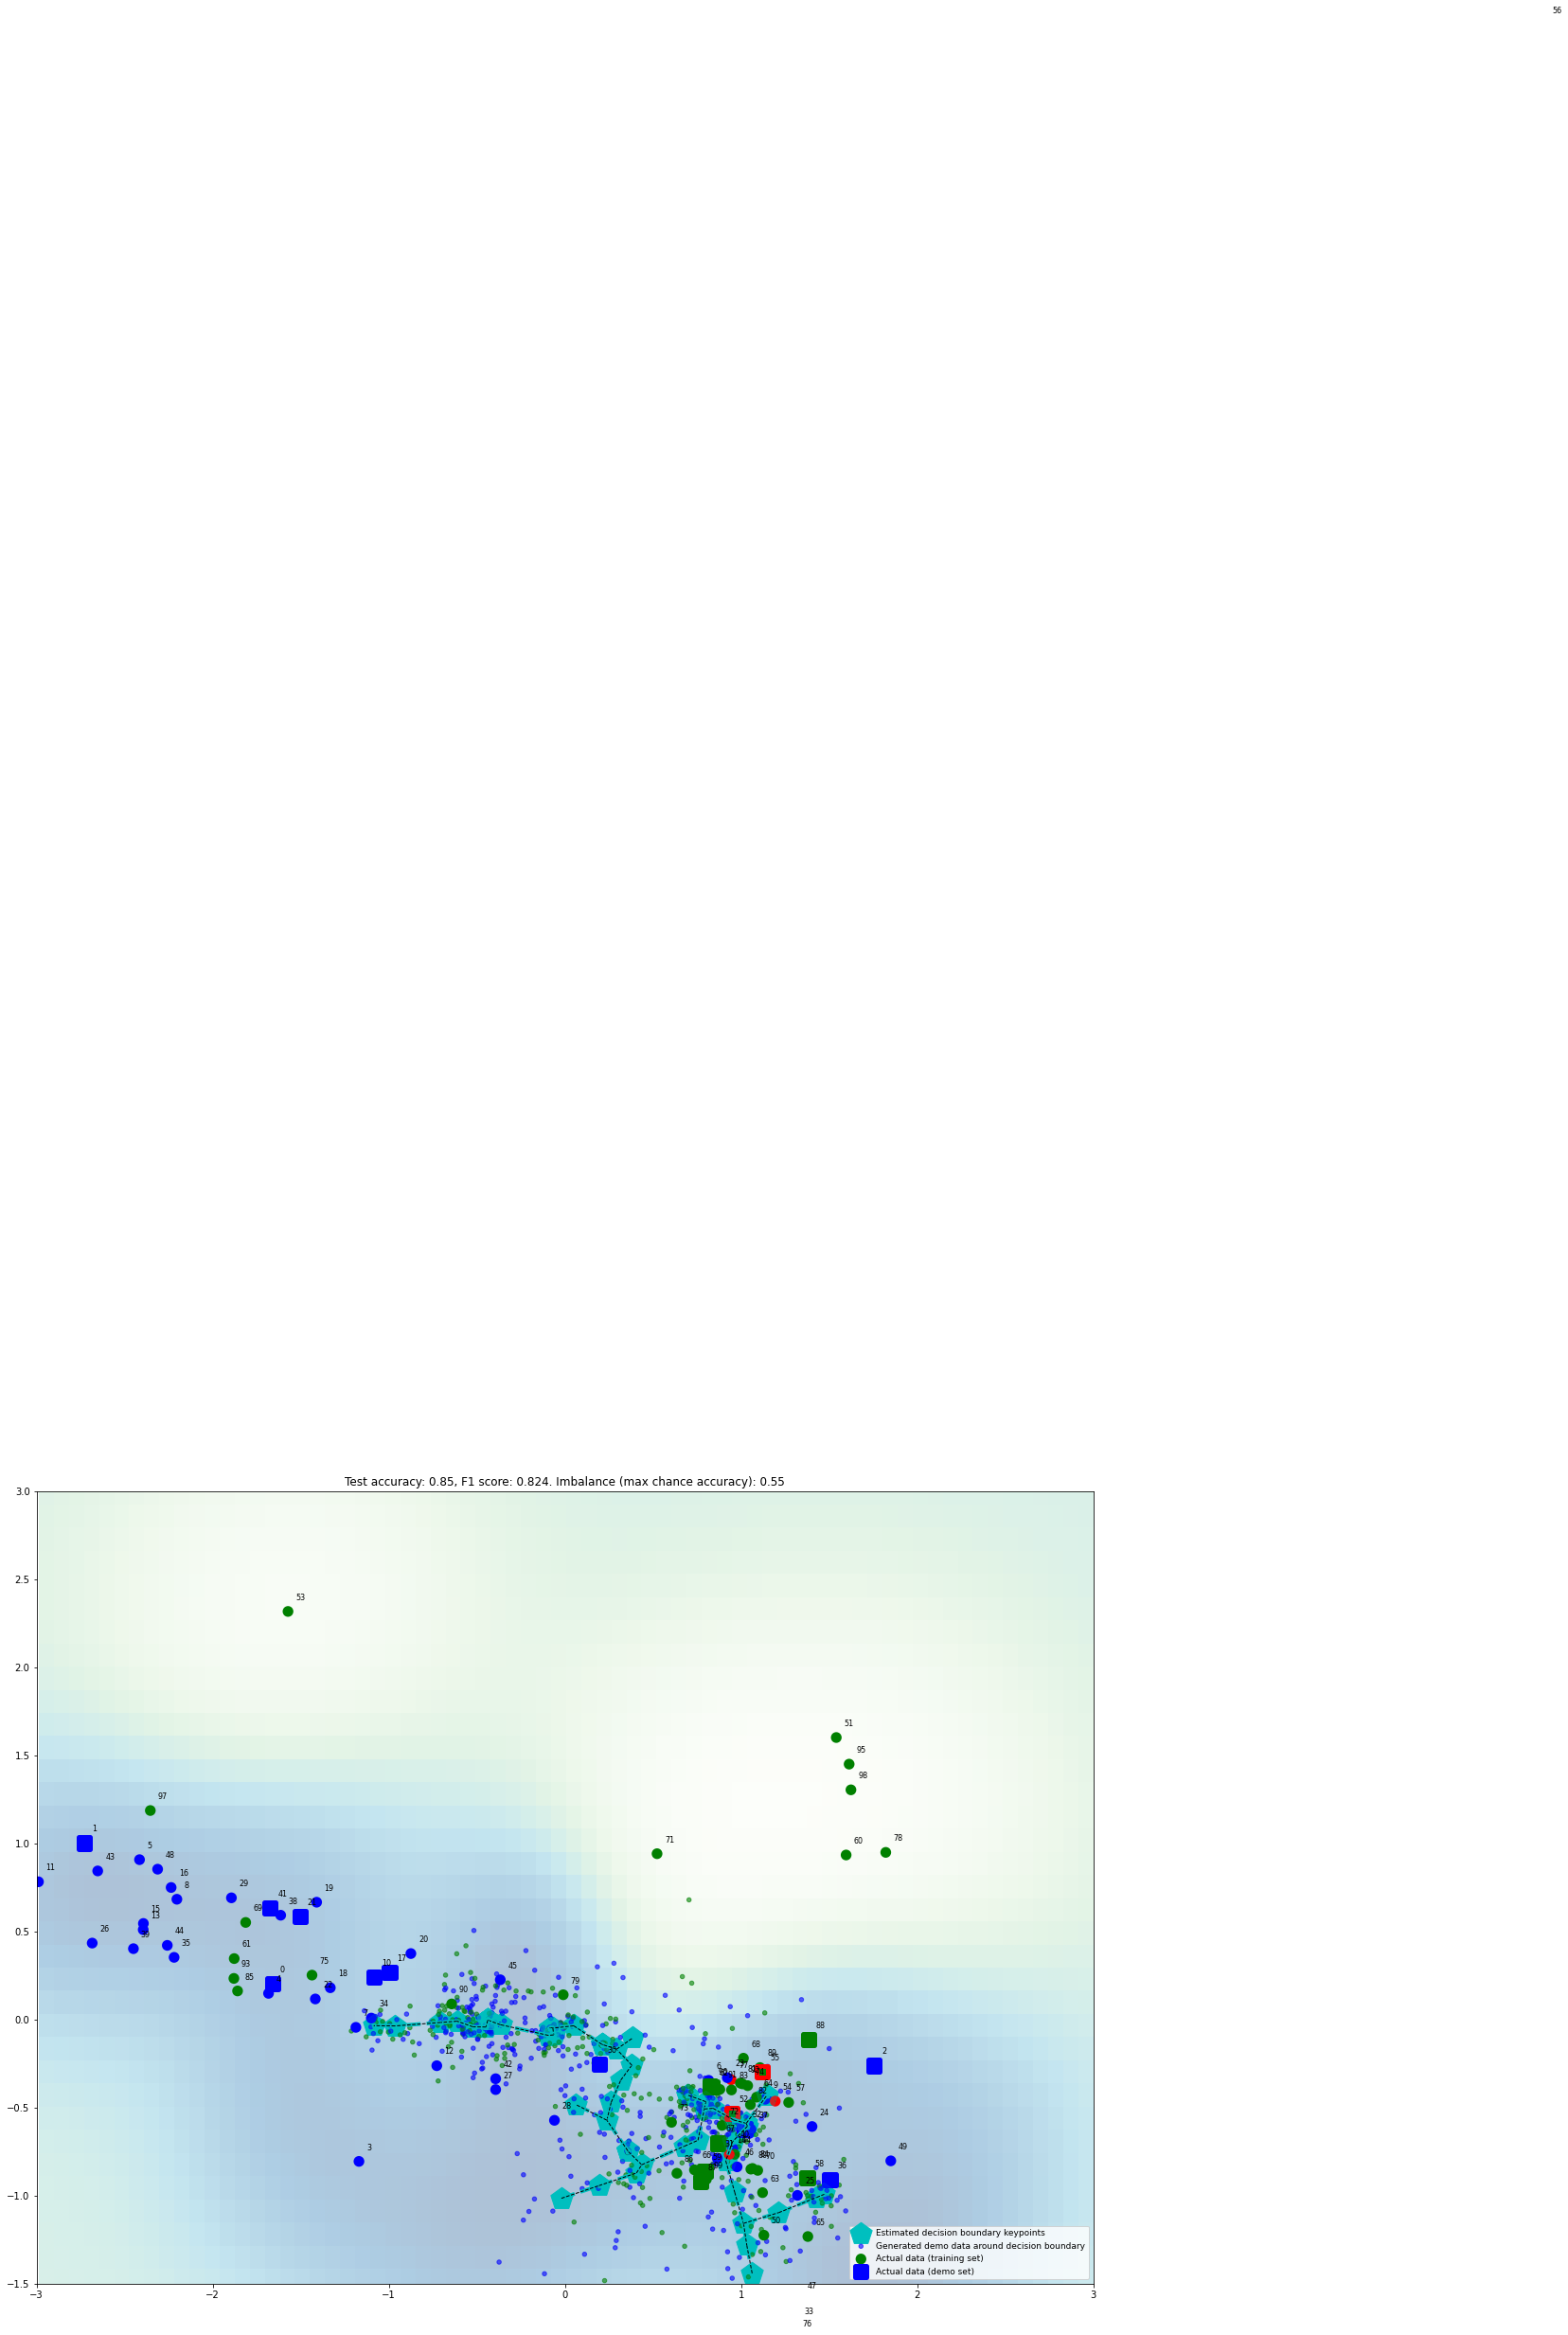

In [95]:
from sklearn.ensemble import RandomForestClassifier

X_np = X_train.to_numpy()
y_np = y_train.income.to_numpy()

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X_np)
x_mixed_transformed = scaler.transform(x_mixed)

n_trees = 20
rf = RandomForestClassifier(n_estimators=n_trees, random_state=RF_RANDOM_STATE)
rf.fit(X_transformed, y_np)

baseline = rf.score(scaler.transform(X_test), y_test.income.to_numpy())
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

plt.figure(figsize=(20, 20))
db = DBPlot(rf, PCA(n_components=2), verbose=1)
db.fit(x_mixed_transformed, y_mixed, training_indices=0.5)
fig = db.plot(plt, generate_testpoints=True)
plt.xlim((-3, 3))
plt.ylim((-1.5, 3))
#fig.show()
plt.savefig("./adult-rf20-decision-boundaries.svg")

Non-private test accuracy: 84.68%
Step 1/3: 0/16
Step 1/3: 1/16
Step 1/3: 2/16
Step 1/3: 3/16
Step 1/3: 4/16
Step 1/3: 5/16
Step 1/3: 7/16
Step 1/3: 8/16
Step 1/3: 10/16
Step 1/3: 12/16
Step 1/3: 13/16
Step 1/3: 14/16
Step 1/3: 15/16
Step 2/3: 0/20
Step 2/3: 1/20
Step 2/3: 2/20
Step 2/3: 3/20
Step 2/3: 4/20
Step 2/3: 5/20
Step 2/3: 6/20
Step 2/3: 7/20
Step 2/3: 8/20
Step 2/3: 9/20
Step 2/3: 10/20
Step 2/3: 11/20
Step 2/3: 12/20
Step 2/3: 13/20
Step 2/3: 14/20
Step 2/3: 15/20
Step 2/3: 16/20
Step 2/3: 17/20
Step 2/3: 18/20
Step 2/3: 19/20
Step 3/3:0/
Step 3/3:1/
Step 3/3:2/
Step 3/3:3/
Step 3/3:4/
Step 3/3:5/
Step 3/3:6/
Step 3/3:7/
No good solution along straight line - trying to find decision boundary on hypersphere surface around known decision boundary point
Found point is too distant from decision boundary (0.08000000000000002) retrying...
Step 3/3:7/
No good solution along straight line - trying to find decision boundary on hypersphere surface around known decision boundary point


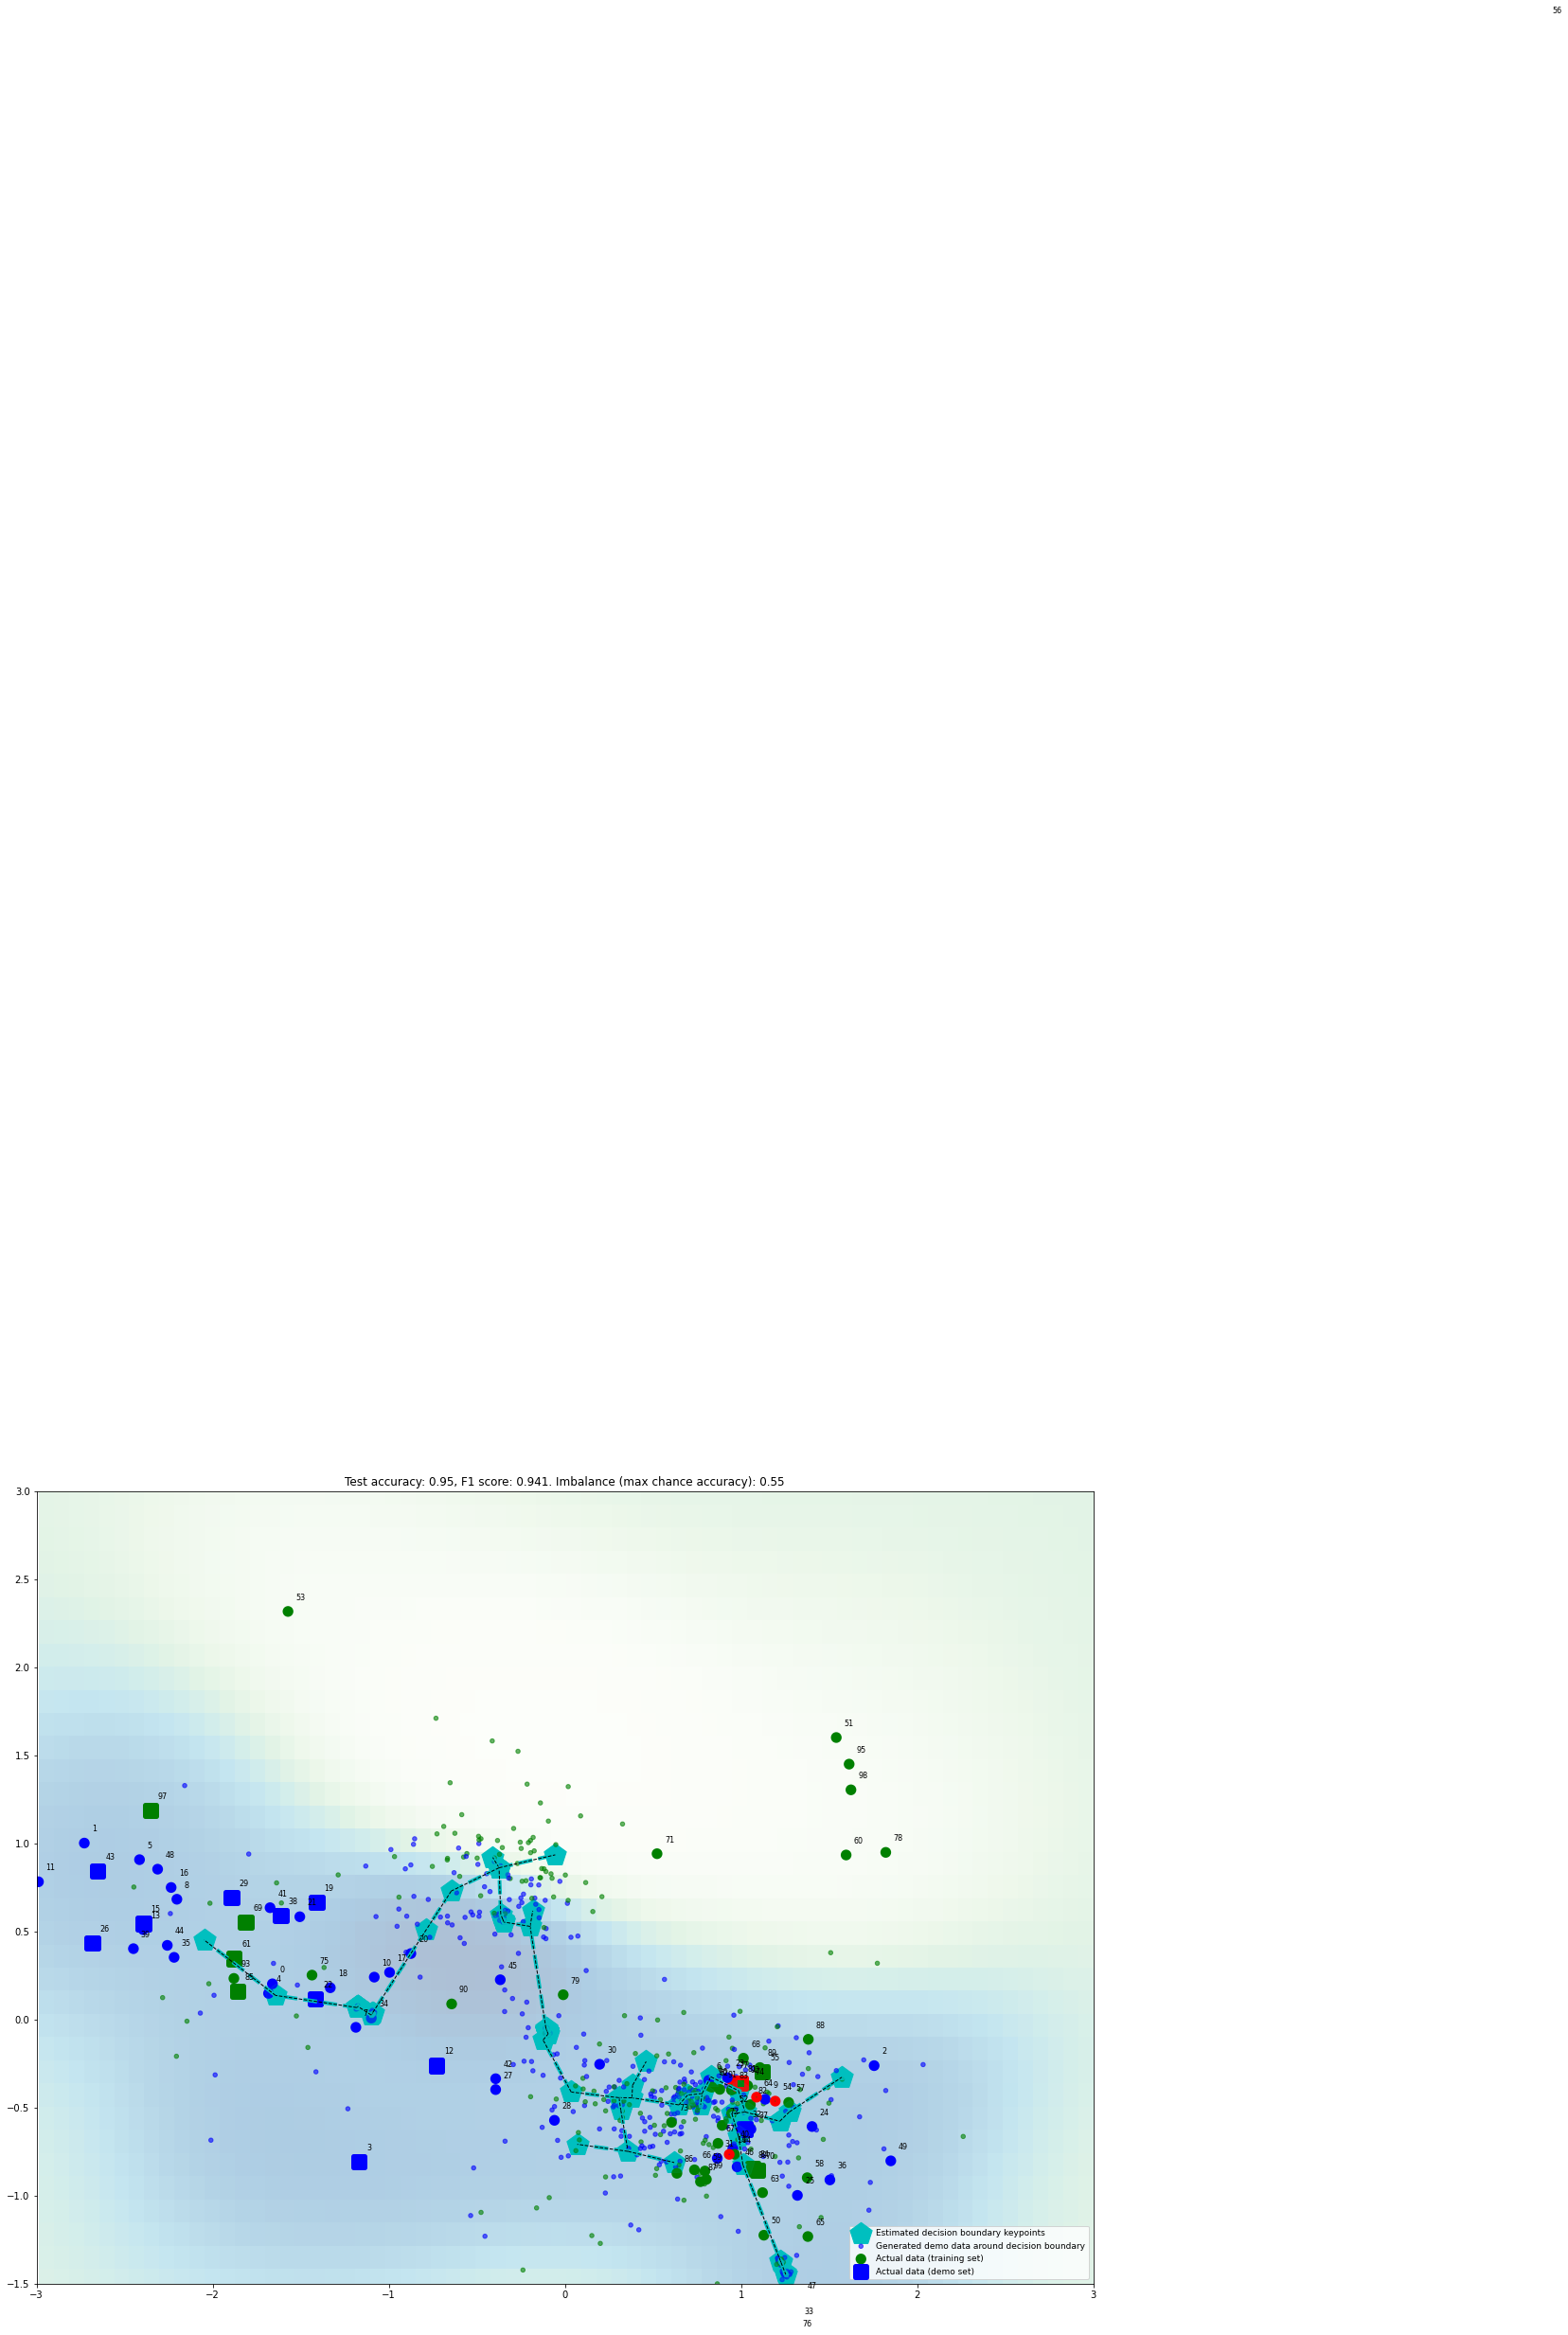

In [97]:
from sklearn.ensemble import RandomForestClassifier

X_np = X_train.to_numpy()
y_np = y_train.income.to_numpy()

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X_np)
x_mixed_transformed = scaler.transform(x_mixed)

n_trees = 100
rf = RandomForestClassifier(n_estimators=n_trees, random_state=RF_RANDOM_STATE)
rf.fit(X_transformed, y_np)

baseline = rf.score(scaler.transform(X_test), y_test.income.to_numpy())
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

plt.figure(figsize=(20, 20))
db = DBPlot(rf, PCA(n_components=2), verbose=1)
db.fit(x_mixed_transformed, y_mixed, training_indices=0.5)
fig = db.plot(plt, generate_testpoints=True)
plt.xlim((-3, 3))
plt.ylim((-1.5, 3))
#fig.show()
plt.savefig("./adult-rf100-decision-boundaries.svg")

In [90]:
plt.show()